In [34]:
import pandas as pd
import numpy as np
import os
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from torch import nn, optim
from torch.autograd import Variable
import torch
import torch.nn.functional as F
import torch.utils.data
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing

In [36]:
os.chdir(r'C:/Users/gbsegura/Documents/AMPD-Projects/archive/nba-shots-streamlit-app') 

X_train = pd.read_pickle('./data/X_train.pkl')
Y_train = pd.read_pickle('./data/Y_train.pkl')
x_test = pd.read_pickle('./data/x_test.pkl')
y_test = pd.read_pickle('./data/y_test.pkl')

data = pd.concat([X_train, Y_train], axis=1)
data = data.rename(columns={'labels':'target'})

data.target.value_counts()

0    52642
1    43409
Name: target, dtype: int64

In [37]:
X = data.drop(['target'], axis=1)
y = data.target

In [38]:
def convert_to_tensor(X, Y, x_test, y_test):
    # making sure the training will use gpu
    #     torch.cuda.set_device(0)
    #     torch.backends.cudnn.benchmark=True
    # convert all dataset to cuda tensor to be able to use the GPU
    dtype = torch.FloatTensor
    X = np.array(X)
    x_test = np.array(x_test)
    Y = np.array(Y)
    y_test = np.array(y_test)
    X_train = torch.tensor(X, device=device).type(dtype)
    x_test = torch.tensor(x_test, device=device).type(dtype)


    Y_train = torch.tensor(Y, device=device).type(dtype)
    y_test = torch.tensor(y_test, device=device).type(dtype)

    Y_train = torch.unsqueeze(Y_train, 1)
    y_test = torch.unsqueeze(y_test, 1)
    return X_train, x_test, Y_train, y_test

from torch.utils.data.dataloader import DataLoader
X_train, x_test, Y_train, y_test = convert_to_tensor(X_train, Y_train, x_test, y_test)

In [39]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(start, 200)
        self.relu1 = nn.ReLU()
        self.dout = nn.Dropout(0.3)
                
        self.fc2 = nn.Linear(200, 200)
        self.prelu = nn.PReLU(1)
        self.dout = nn.Dropout(0.3)
        
        self.fc6 = nn.Linear(200, 100)
        self.prelu = nn.PReLU(1)
        
        self.out = nn.Linear(100, 1)
        self.out_act = nn.Sigmoid()
        
    def forward(self, input_):
        a1 = self.fc1(input_)
        h1 = self.relu1(a1)
        dout = self.dout(h1)
        
        a2 = self.fc2(dout)
        h2 = self.prelu(a2)
        dout = self.dout(h2)
        
        a6 = self.fc6(dout)
        h6 = self.prelu(a6)
        
        a7 = self.out(h6)
        
        y = self.out_act(a7)
        return y

In [40]:
start = len(X.columns)

In [41]:
model = Classifier()
criterion = nn.BCELoss() ## loss function for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001) ## adam optimizer

In [ ]:
# torch.backends.cudnn.benchmark=True
n_epochs = 5000
e_losses = []
former_loss = 9999999999999999999999999999

for epoch in range(n_epochs):
    
    # forward pass
    outputs = model.forward(X_train)

    # calculate loss (MSE)
    loss = criterion(outputs, Y_train)
    e_losses.append(loss.data)

    # compute gradients
    loss.backward()
    
    # perform one step in the oposite direction to the gradient (update weights)
    optimizer.step()
    
    # clear gradient values after weights are updated
    optimizer.zero_grad()
    
    if loss <= min(e_losses):
        torch.save(model.state_dict(), '.\models\model_pytorch.pt')
        print('model saved at epoch {}, with loss {}'.format(epoch, loss.item()))
        last_epoch = epoch
        last_loss = loss.item()
    
    if epoch % 100 == 0:
        print('epoch {}, loss {}'.format(epoch, loss.item()))
#         current_loss = loss.item()
#         if former_loss - current_loss < 0:
#             print('early stopping at epoch {}, model saved at epoch {}, with loss {}'.format(epoch, last_epoch, last_loss))
#             break
#         else:
#             former_loss = current_loss



model saved at epoch 0, with loss 0.6966571807861328
epoch 0, loss 0.6966571807861328
model saved at epoch 1, with loss 0.6966571807861328
model saved at epoch 2, with loss 0.6966571807861328
model saved at epoch 3, with loss 0.6966571807861328
model saved at epoch 4, with loss 0.6966571807861328
model saved at epoch 5, with loss 0.6966571807861328
model saved at epoch 6, with loss 0.6966571807861328
model saved at epoch 7, with loss 0.6966571807861328
model saved at epoch 8, with loss 0.6966571807861328
model saved at epoch 9, with loss 0.6966571807861328
model saved at epoch 10, with loss 0.6966571807861328
model saved at epoch 11, with loss 0.6966571807861328
model saved at epoch 12, with loss 0.6966571807861328
model saved at epoch 13, with loss 0.6966571807861328
model saved at epoch 14, with loss 0.6966571807861328
model saved at epoch 15, with loss 0.6966571807861328
model saved at epoch 16, with loss 0.6966571807861328
model saved at epoch 17, with loss 0.6966571807861328
model

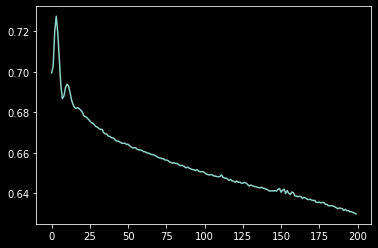

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use(['dark_background'])        
plt.plot(e_losses)

In [45]:
model = Classifier()
#model.load_state_dict(torch.load(r'.\models\model_pytorch.pt'))
model.eval()

Classifier(
  (fc1): Linear(in_features=826, out_features=200, bias=True)
  (relu1): ReLU()
  (dout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (prelu): PReLU(num_parameters=1)
  (fc6): Linear(in_features=200, out_features=100, bias=True)
  (out): Linear(in_features=100, out_features=1, bias=True)
  (out_act): Sigmoid()
)

In [46]:

def predict_new_data(x_test, y_test, model):
    # switch to evaluation mode
    model = model.eval()
    dtype = torch.FloatTensor

    x_test = torch.tensor(x_test).type(dtype)
    with torch.no_grad():
        y_pred_prob = model.forward(x_test).cpu().numpy()

    y_pred = y_pred_prob >= 0.5
    y_pred = y_pred.astype(int)
    y_test = y_test.cpu().numpy()
    accuracy = metrics.accuracy_score(y_pred, y_test).astype(str)
    print('\n\naccuracy is ' + accuracy)

    precision = metrics.precision_score(y_test, y_pred).astype(str)
    print('precision is ' + precision)
    recall = metrics.recall_score(y_test, y_pred).astype(str)
    print('recall is ' + recall)
    auc = metrics.roc_auc_score(np.asarray(y_test), y_pred).astype(str)
    print('auc is ' + auc)

    f1 = 2*((precision.astype(np.float64)*recall.astype(np.float64))/(precision.astype(np.float64)+recall.astype(np.float64)))
    print('f1-score is ' + f1.astype(str))
    
    return y_pred, y_pred_prob

y_pred_train, y_pred_train_prob = predict_new_data(X_train, Y_train, model)
y_pred_test, y_pred_test_prob= predict_new_data(x_test, y_test, model)

C:\Users\gbsegura\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  




accuracy is 0.4473769143475862
precision is 0.44102545339236277
recall is 0.8330300168167891
auc is 0.48119720133419525
f1-score is 0.5767212644136458


C:\Users\gbsegura\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  




accuracy is 0.44765444437503904
precision is 0.4417023143577931
recall is 0.8334023178807947
auc is 0.48096322948029
f1-score is 0.5773890601476809


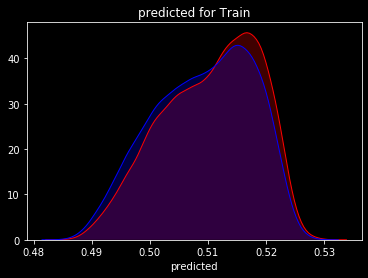

mean for red 0.5105012766259686
mean for blue 0.5092261874385204


In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(num=None, figsize=(12, 10))
%matplotlib inline

Y_train_pd = Y_train.cpu().numpy()
preds = pd.DataFrame({'target':pd.Series(map(lambda x: x[0], Y_train_pd)), 'predicted':pd.Series(map(lambda x: x[0], y_pred_train_prob))})

plt.style.use(['dark_background'])
plot = sns.distplot(preds['predicted'][preds['target']==0], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 1}, color='red')
plot = sns.distplot(preds['predicted'][preds['target']==1], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 1}, color='blue')
plt.title('predicted for Train')
plt.show(plot)
print('mean for red '+str(preds['predicted'][preds['target']==0].mean()))
print('mean for blue '+str(preds['predicted'][preds['target']==1].mean()))